In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [0]:
device = torch.device('cuda')

In [0]:
class AMP_layer(nn.Module): #this is the pwlin AMP implementation of found on boergerding et al, 
  def __init__(self, A,device=device):
   super(AMP_layer,self).__init__()
   self.N= A.shape[1]
   self.M= A.shape[0]
   self.A_t= nn.Parameter(torch.tensor(A, device= device,requires_grad=True).float())
   self.A_p= nn.Parameter(torch.tensor(A.T, device= device, requires_grad=False).float())
   self.theta_0=nn.Parameter(torch.tensor(1.0,device= device,requires_grad=True))
   self.theta_1= nn.Parameter(torch.tensor(1.0,device= device,requires_grad=True))
   self.theta_2=nn.Parameter(torch.tensor(1.0,device= device,requires_grad=True))
   self.theta_3=nn.Parameter(torch.tensor(1.0,device= device,requires_grad=True))
   self.theta_4=nn.Parameter(torch.tensor(1.0,device= device,requires_grad=True))
   self.beta=nn.Parameter(torch.tensor(1.0,device= device,requires_grad=True))
  
  def non_linearity(self,r,rvar,theta): # a general non-linearity would 
   ab0 = theta[0]                       #need to have inputs (r, variance_estimator, params_list)
   ab1 = theta[1]                       # and outputs of form (xhat, dvtv of vector xhat wrt vector r)
   sl0 = theta[2]
   sl1 = theta[3]
   sl2 = theta[4]

   # scale each column by sqrt(rvar)
   scale_out = torch.sqrt(rvar)
   scale_in = 1/scale_out
   rs = torch.sign(r*scale_in)
   ra = torch.abs(r*scale_in)
   
   # split the piecewise linear function into regions
   rgn0 = ( ra<ab0).float()#type(torch.FloatTensor)
   rgn1 = (( ra<ab1).float() - rgn0)#type(torch.FloatTensor)
   rgn2 = ( ra>=ab1).float()#type(torch.FloatTensor)
   xhat = scale_out * rs*(
          rgn0*sl0*ra +
          rgn1*(sl1*(ra - ab0) + sl0*ab0 ) +
          rgn2*(sl2*(ra - ab1) +  sl0*ab0 + sl1*(ab1-ab0) )
          )
   dxdr =  sl0*rgn0 + sl1*rgn1 + sl2*rgn2
   
   dxdr = torch.mean(dxdr,1, keepdim=True)
   
   return (xhat,dxdr)

  def forward(self, inputs):
        
        r= inputs[0]+torch.mm(inputs[1],self.A_t)
        nor= (torch.norm(inputs[1],dim=-1,keepdim=True))**2
        x_hat, dxdr= self.non_linearity(r,nor, [self.theta_0, self.theta_1,self.theta_2,self.theta_3,self.theta_4,])
        v= inputs[2]- torch.mm(x_hat,self.A_p) + self.beta*dxdr*self.N/self.M*inputs[1]
        return (x_hat,v)

In [0]:
class Model_AMP(nn.Module):                             #constructs a meta-module
  def __init__(self, A,num_layers=7):                   #outputs a list of tensors
    super(Model_AMP,self).__init__()                    #each of  which can be input to loss function
    self.num_layers= num_layers
    self.model_list= [None]*num_layers
    for i in range(0, self.num_layers):
      self.model_list[i]=AMP_layer(A)
    self.outputs= [None]*self.num_layers
   
  def forward(self,inputs,):
    i_layer=0
    self.outputs[0]= self.model_list[0](inputs)
    for i_layer in range(1,self.num_layers):
      self.outputs[i_layer]=self.model_list[i_layer]([self.outputs[i_layer-1][0],self.outputs[i_layer-1][1],inputs[2]])
    return self.outputs
      

In [0]:
N=500
num_epochs=100
M=int(0.5*N)
A= np.random.randn(M,N)/M**0.5
rho=0.05#sparsity level
snr_dB=40
noise_scale=10**(-snr_dB/10)
num_layers=10
model_AMP= Model_AMP(A, num_layers).to(device)

def data_gen(n_sims,A=A,snr=40,rho=0.11):
    N= A.shape[1]
    M= A.shape[0]
    mask_vecs=np.random.binomial(1,rho,size=(n_sims,N))#*np.random.exponential(scale=1, size=(N,n_sims))
    x_true_all= mask_vecs**0.5*np.random.randn(n_sims,N)
    noise_scale=10**(-snr/10)
    y_all= x_true_all@A.T + noise_scale**0.5*np.random.randn(n_sims,M)*((rho*N/M)**0.5)
    n_sims_1=int(n_sims/100)
    gamma_vecs_1=np.random.binomial(1,rho,size=(n_sims_1,N))
    x_true_all_vali= gamma_vecs_1**0.5*np.random.randn(n_sims_1,N)
    y_all_vali= x_true_all_vali@A.T + 10**(-snr*0.5/10)*np.random.randn(n_sims_1,M)*((rho*N/M)**0.5)
    input_x_1=np.zeros_like(x_true_all_vali)
    print(np.sum((x_true_all@A.T)**2)/np.sum((y_all-x_true_all@A.T)**2))
    return x_true_all, y_all

In [0]:
def data_gen(n_sims,A=A,snr=40,rho=0.11):
    N= A.shape[1]
    M= A.shape[0]
    mask_vecs=np.random.binomial(1,rho,size=(n_sims,N))#*np.random.exponential(scale=1, size=(N,n_sims))
    x_true_all= mask_vecs**0.5*np.random.randn(n_sims,N)
    noise_scale=10**(-snr/10)
    y_all= x_true_all@A.T + noise_scale**0.5*np.random.randn(n_sims,M)*((rho*N/M)**0.5)
    n_sims_1=int(n_sims/100)
    gamma_vecs_1=np.random.binomial(1,rho,size=(n_sims_1,N))
    x_true_all_vali= gamma_vecs_1**0.5*np.random.randn(n_sims_1,N)
    y_all_vali= x_true_all_vali@A.T + 10**(-snr*0.5/10)*np.random.randn(n_sims_1,M)*((rho*N/M)**0.5)
    input_x_1=np.zeros_like(x_true_all_vali)
    print(np.sum((x_true_all@A.T)**2)/np.sum((y_all-x_true_all@A.T)**2))
    return x_true_all, y_all

In [72]:
#%%capture
snr_train=40
x_true_all_, y_all_= data_gen(1000,snr=snr_train)
x_true_all=torch.from_numpy(x_true_all_).float().to(device)
y_all=torch.from_numpy(y_all_).float().to(device)
y_all_zero=torch.from_numpy(0*y_all_).float().to(device)
input_x=torch.from_numpy(np.zeros_like(x_true_all_)).float().to(device)
#input_x_1=torch.from_numpy(np.zeros_like(x_true_all_vali)).float().to(device)
#out_list=model_AMP([input_x,y_all,y_all])

optim_list= [None]*num_layers
lr_1=3e-2
lr_2= 8e-3
lr= lr_1
for i in range(num_layers):
  if i >=2:
    lr= lr_2
  optim_list[i]=torch.optim.Adam(model_AMP.model_list[i].parameters(), lr=lr)

9978.840373575265


In [73]:
%%time
%%capture
torch.cuda.empty_cache()
num_epochs=500
for i_layer in range(num_layers):
  opt= optim_list[i_layer]
  criterion = nn.MSELoss()
  for i_epoch in range(num_epochs):
    opt.zero_grad()
    x_true_all_, y_all_= data_gen(200,snr=snr_train, rho=0.10)
    x_true_all=torch.from_numpy(x_true_all_).float().to(device)
    y_all=torch.from_numpy(y_all_).float().to(device)
    input_x=torch.from_numpy(np.zeros_like(x_true_all_)).float().to(device)
    outputs=model_AMP([input_x,y_all,y_all])
    loss= criterion(outputs[i_layer][0],x_true_all)
    #if i_epoch%5==0:
    # print("layer: %2.0f i:%2.0f, loss:%f"%(i_layer,i_epoch,loss.item()))
    loss.backward()
    opt.step()
  max_iter_2=i_layer
#   for param in model_AMP.model_list[i_layer].parameters():
#     param.requires_grad_(False)
   

CPU times: user 5min 28s, sys: 3min 19s, total: 8min 47s
Wall time: 4min 33s


In [0]:
for i_layer in range(num_layers):
  for param in model_AMP.model_list[i_layer].parameters():
      param.requires_grad_(True)

10035.21728529115
988.9816683917957
998.6857542492588
1000.6168386784109
996.3885686097199
997.7277412217904
1001.6935693977373
997.5920746224734
995.3007970412327
997.674975818862


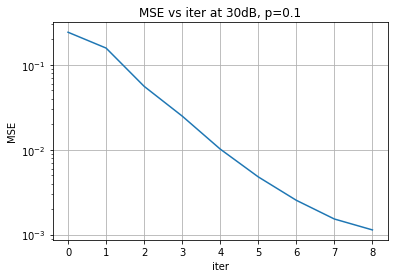

In [90]:
#max_iter_2=8
def error_prob_detect(x,x_hat, thresh_x_hat=10, thresh_x=1e-2):
    ind_x_true= (np.abs(x)>thresh_x).astype(np.float64)
    ind_x_hat=((x_hat)>thresh_x_hat).astype(np.float64)
    f_a= np.sum(np.abs(ind_x_hat)*(1-ind_x_true))/np.sum(1-ind_x_true)
    m_d=np.sum(np.abs(1-ind_x_hat)*(ind_x_true))/np.sum(ind_x_true)
    return f_a,m_d

x_true_all, y_all=data_gen(1000)
num_snr=10
snr_list=np.linspace(0,30,num_snr)
mse_list= [0]*max_iter_2
rho_list=np.linspace(0.01,0.2,num_snr)
list_lists=[mse_list,rho_list,snr_list]
plot_index=0
fa_list_snr= [0]*len(snr_list)
md_list_snr=[0]*len(snr_list)
fa_list_iter= [0]*(max_iter_2)
md_list_iter= [0]*(max_iter_2)
fa_list_rho= [0]*len(snr_list)
md_list_rho=[0]*len(snr_list)
if plot_index==0:
  err_list= [0]*(max_iter_2)
else:
  err_list= [0]*len(snr_list)
x1=np.linalg.norm(x_true_all)
x_norm=np.mean(x_true_all**2)
num_avg=10
for i_list,_ in enumerate(list_lists[plot_index]):
        n_sims_plot=5000
        if plot_index==0:
          x_true_all_, y_all_=data_gen(n_sims_plot, snr=30, rho=0.1)
          y_all=torch.from_numpy(y_all_).float().to(device)
          input_x=torch.from_numpy(np.zeros_like(x_true_all_)).float().to(device)
          outputs=model_AMP([input_x,y_all,y_all])
          z=outputs[i_list][0].cpu().detach().numpy()
          err_list[i_list]+= np.mean((x_true_all_-z)**2)/np.mean(x_true_all_**2)
#           fa_list_iter[i_list], md_list_iter[i_list] = error_prob_detect(x_norm_1,z_norm, thresh_x=0.00001, thresh_x_hat=0.1)
          
        elif plot_index==2:
          x_true_all, y_all=data_gen(n_sims_plot, snr=10, rho=rho_list[i_list])
          input_x=np.zeros_like(x_true_all)
          z=Models_list[max_iter_2].predict([input_x,y_all,y_all])
          z_norm= norm_vector(z)
          x_norm_1= norm_vector(x_true_all)
          err_list[i_list]+= np.sum((x_true_all-z)**2)*(0.1)**2/(x_norm*n_sims_plot*rho_list[i_list]**2)
          fa_list_rho[i_list], md_list_rho[i_list] = error_prob_detect(x_norm_1,z_norm, thresh_x=0.00001, thresh_x_hat=0.001)
          
          
        elif plot_index==1:  
          x_true_all, y_all=data_gen(n_sims_plot//4, snr=snr_list[i_list], rho=0.1)
          input_x=np.zeros_like(x_true_all)
          z=Models_list[max_iter_2].predict([input_x,y_all,y_all])
          z_norm= norm_vector(z)
          x_norm_1= norm_vector(x_true_all)
          err_list[i_list]+= 2*np.sum((x_true_all-z)**2)/(x_norm*n_sims_plot)
          fa_list_snr[i_list], md_list_snr[i_list] = error_prob_detect(x_norm_1,z_norm, thresh_x=0.00001, thresh_x_hat=0.1)
        
        

if plot_index==0:
  plt.semilogy(err_list)
  plt.title('MSE vs iter at 30dB, p=0.1')
  plt.xlabel('iter')
  plt.ylabel('MSE')
  plt.grid()

elif plot_index==1:
  plt.semilogy(snr_list,err_list)
  plt.title('MSE vs SNR at p=0.1')
  plt.xlabel('SNR')
  plt.ylabel('MSE')
  plt.grid()
  

elif plot_index==2:
  plt.semilogy(rho_list,err_list)
  plt.title('MSE vs p at SNR=30dB')
  plt.xlabel('p')
  plt.ylabel('MSE')
  plt.grid()

In [49]:
!nvidia-smi

Tue Oct 29 19:28:02 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.50       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    71W / 149W |   3155MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

(50, 150)

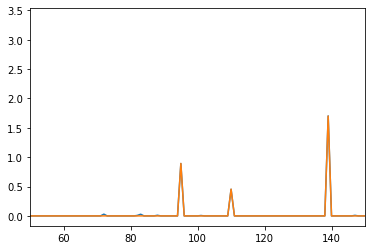

In [88]:
n1=50
n2=100
n3=14
plt.figure()
plt.plot(np.abs(z[n3,:]))
plt.plot(np.abs(x_true_all_[n3,:]))
plt.xlim([n1,n1+n2])

In [0]:
%matplotlib inline